In [1]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random
import utility
import rasterio
import wandb
import tqdm
import shutil
import pandas as pd

In [2]:
from utility import ShipDataset
from utility import ShipDataset_YOLO

In [3]:
# if matplot doesnt work
import matplotlib
#matplotlib.use('TkAgg')

# same seed
torch.manual_seed(0)

# garbage collection
import gc
gc.collect()
torch.cuda.empty_cache()

# CUDA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
# constants, keep as is
batch_size = 1
all_thresholds = np.arange(0.1, 1, 0.05)

#### Faster R-CNN and RetinaNet Datasets and Loaders

In [5]:
val_dataset = ShipDataset(
    path = 'test_yolo/',
    #transform=transform
)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,collate_fn=utility.collate_fn)
len(val_dataset)

736

In [6]:
inshore_dataset = ShipDataset(
    path = 'in',
    #transform=transform
)

inshore_loader = torch.utils.data.DataLoader(inshore_dataset, batch_size=batch_size,collate_fn=utility.collate_fn)
len(inshore_dataset)

117

In [7]:
offshore_dataset = ShipDataset(
    path = 'off',
    #transform=transform
)

offshore_loader = torch.utils.data.DataLoader(offshore_dataset, batch_size=batch_size,collate_fn=utility.collate_fn)
len(offshore_dataset)

619

#### YOLO Data

In [8]:
val_dataset_yolo = ShipDataset_YOLO(
    path = 'test_yolo/',
    #transform=transform
)

val_loader_yolo = torch.utils.data.DataLoader(val_dataset_yolo, batch_size=batch_size,collate_fn=utility.collate_fn)
len(val_loader_yolo)

736

In [9]:
inshore_dataset_yolo = ShipDataset_YOLO(
    path = 'in',
    #transform=transform
)

inshore_loader_yolo = torch.utils.data.DataLoader(inshore_dataset_yolo, batch_size=batch_size,collate_fn=utility.collate_fn)
len(inshore_dataset_yolo)

117

In [10]:
offshore_dataset_yolo = ShipDataset_YOLO(
    path = 'off',
    #transform=transform
)

offshore_loader_yolo = torch.utils.data.DataLoader(offshore_dataset_yolo, batch_size=batch_size,collate_fn=utility.collate_fn)
len(offshore_dataset_yolo)

619

## RetinaNet Results

In [11]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=2)
retina.load_state_dict(torch.load("models/retina300R2.pt"))
retina.eval()
retina.to(device)
print()

In [12]:
retina_results = []
for t in all_thresholds:
    temp = utility.get_metric(retina,val_loader,t,device)
    retina_results.append(temp)

/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


##### Retina Test Results

In [13]:
cols = ["Precision", "Recall", "AP" , "f1" ,"mAP", "Time (seconds)", "Threshold"]
retina_results_df = pd.DataFrame(retina_results, columns=cols)
retina_results_df

,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.193612,0.907485,0.750603,0.319136,0.750603,51.858605,0.10
1,0.247921,0.902860,0.749572,0.389020,0.749572,50.296803,0.15
2,0.299986,0.897813,0.748215,0.449710,0.748215,51.589887,0.20
3,0.342517,0.894029,0.747000,0.495282,0.747000,50.775888,0.25
4,0.382220,0.887721,0.744699,0.534363,0.744699,50.778908,0.30
5,0.420261,0.880992,0.741995,0.569062,0.741995,50.781836,0.35
6,0.456967,0.873003,0.738501,0.599913,0.738501,50.915504,0.40
7,0.491048,0.865013,0.734684,0.626466,0.734684,50.621852,0.45
8,0.523590,0.858705,0.731477,0.650526,0.731477,51.141124,0.50
9,0.555586,0.849033,0.726220,0.671657,0.726220,50.632411,0.55


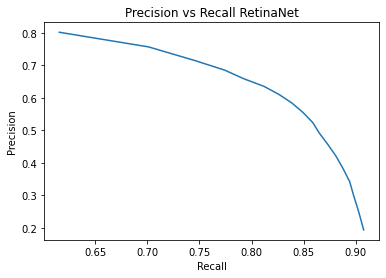

In [14]:
precision = retina_results_df['Precision']
recall = retina_results_df['Recall']
# Create plot
plt.plot(recall, precision)
# Add axis labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall RetinaNet')
# Show the plot
plt.show()

In [15]:
# from Precision Recall, best threhold
retina_threshold = 0.85

##### Retina Test Inshore Results

In [16]:
retina_results_in = []
temp = utility.get_metric(retina,inshore_loader,retina_threshold,device)
retina_results_in.append(temp)
retina_results_in_df = pd.DataFrame(retina_results_in, columns=cols)
retina_results_in_df

/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.4294,0.502831,0.314267,0.463224,0.314267,8.418667,0.85


##### Retina Test Offshore Results

In [17]:
retina_results_off = []
temp = utility.get_metric(retina,offshore_loader,retina_threshold,device)
retina_results_off.append(temp)
retina_results_off_df = pd.DataFrame(retina_results_off, columns=cols)
retina_results_off_df

/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.917818,0.888963,0.854783,0.90316,0.854783,41.372282,0.85


## Faster R-CNN Results

In [18]:
faster = torchvision.models.detection.fasterrcnn_resnet50_fpn()
num_classes = 2  # 1 class (ship) + background
# get number of input features for the classifier
in_features = faster.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
faster.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
faster.load_state_dict(torch.load("models/faster300ep.pt"))
faster.eval()
faster.to(device)
print()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [19]:
faster_results = []
for t in all_thresholds:
    temp = utility.get_metric(faster,val_loader,t,device)
    faster_results.append(temp)

/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


##### Faster R-CNN Test Results

In [20]:
faster_results_df = pd.DataFrame(faster_results, columns=cols)
faster_results_df

,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.728929,0.941968,0.929268,0.821867,0.929268,52.869533,0.10
1,0.756848,0.941127,0.928642,0.838988,0.928642,52.792265,0.15
2,0.773892,0.939865,0.927675,0.848842,0.927675,52.795727,0.20
3,0.857472,0.938604,0.926691,0.896206,0.926691,53.302117,0.25
4,0.874461,0.937342,0.925595,0.904810,0.925595,53.337578,0.30
5,0.883776,0.936922,0.925225,0.909573,0.925225,53.008185,0.35
6,0.894397,0.933137,0.921862,0.913357,0.921862,52.404661,0.40
7,0.904199,0.932717,0.921485,0.918236,0.921485,52.809762,0.45
8,0.913636,0.929773,0.918808,0.921634,0.918808,53.456548,0.50
9,0.921790,0.926829,0.916104,0.924303,0.916104,53.679294,0.55


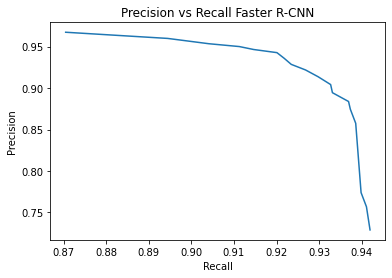

In [22]:
precision = faster_results_df['Precision']
recall = faster_results_df['Recall']
# Create plot
plt.plot(recall, precision)
# Add axis labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Faster R-CNN')
# Show the plot
plt.show()

In [21]:
# from precision-recall curve get best threshold
faster_threshold = 0.7

##### Faster R-CNN Test Inshore Results

In [23]:
faster_results_in = []
temp = utility.get_metric(faster,inshore_loader,faster_threshold,device)
faster_results_in.append(temp)
faster_results_in_df = pd.DataFrame(faster_results_in, columns=cols)
faster_results_in_df

/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.893773,0.828992,0.804873,0.860164,0.804873,8.588108,0.7


##### Faster R-CNN Test Offshore Results

In [24]:
faster_results_off = []
temp = utility.get_metric(faster,offshore_loader,faster_threshold,device)
faster_results_off.append(temp)
faster_results_off_df = pd.DataFrame(faster_results_off, columns=cols)
faster_results_off_df

/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:465: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.969374,0.973913,0.968109,0.971638,0.968109,43.571148,0.7


## YOLO Results

In [26]:
path = "models/yolov7d6.pt"
yolo = torch.hub.load("WongKinYiu/yolov7","custom",f"{path}",trust_repo=True)
yolo.eval()
yolo.to(device)
print()

Using cache found in /home/alex/.cache/torch/hub/WongKinYiu_yolov7_main

                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                 

Adding autoShape... 



In [51]:
yolo_thresholds = np.arange(0,1,0.1)


In [52]:
yolo_results = []
for t in yolo_thresholds:
    temp = utility.get_metric_YOLO(yolo,val_loader_yolo,t)
    yolo_results.append(temp)

Precision: 0.932 
 Recall: 0.501 
 AP: 0.486 
 F1: 0.652 
 mAP 0.486 
 time: 32.460 
 threshold: 0.25


/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:689: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


#### YOLO Results

In [44]:
yolo_results_df = pd.DataFrame(yolo_results, columns=cols)
yolo_results_df

,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.931925,0.500841,0.486124,0.651532,0.486124,32.441025,0.0
1,0.931925,0.500841,0.486124,0.651532,0.486124,32.469778,0.1
2,0.931925,0.500841,0.486124,0.651532,0.486124,32.238330,0.2
3,0.948018,0.452481,0.440612,0.612582,0.440612,32.646528,0.3
4,0.960603,0.348612,0.341314,0.511571,0.341314,32.233471,0.4
5,0.967949,0.253995,0.249914,0.402398,0.249914,32.562675,0.5
6,0.978022,0.149706,0.148230,0.259664,0.148230,32.445224,0.6
7,0.991597,0.049622,0.049572,0.094513,0.049572,32.404490,0.7
8,1.000000,0.003364,0.003364,0.006706,0.003364,32.138319,0.8
9,0.000000,0.000000,0.000000,0.000000,0.000000,32.038825,0.9


/tmp/ipykernel_7087/3232789476.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


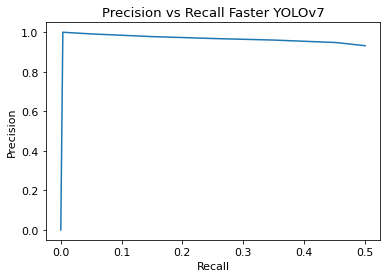

In [45]:
precision = yolo_results_df['Precision']
recall = yolo_results_df['Recall']
# Create plot
plt.plot(recall, precision)
# Add axis labels and title
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Faster YOLOv7')
# Show the plot
plt.show()

In [46]:
# from precision-recall curve get best threshold
yolo_threshold = 0.25

##### YOLO Test Inshore Results

In [49]:
yolo_results_in = []
temp = utility.get_metric_YOLO(yolo,inshore_loader_yolo,yolo_threshold)
yolo_results_in.append(temp)
yolo_results_in_df = pd.DataFrame(yolo_results_in, columns=cols)
yolo_results_in_df

Precision: 0.844 
 Recall: 0.140 
 AP: 0.130 
 F1: 0.241 
 mAP 0.130 
 time: 5.369 
 threshold: 0.25


/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:689: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.843537,0.14043,0.129628,0.240777,0.129628,5.368825,0.25


##### YOLO Test Offshore Results

In [50]:
yolo_results_off = []
temp = utility.get_metric_YOLO(yolo,offshore_loader_yolo,yolo_threshold)
yolo_results_off.append(temp)
yolo_results_off_df = pd.DataFrame(yolo_results_off, columns=cols)
yolo_results_off_df

Precision: 0.943 
 Recall: 0.714 
 AP: 0.695 
 F1: 0.813 
 mAP 0.695 
 time: 27.100 
 threshold: 0.25


/home/alex/school/DSC180A/SAR-satelite-image-ship-detection/alex_notebooks/utility.py:689: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


,Precision,Recall,AP,f1,mAP,Time (seconds),Threshold
0,0.943413,0.713712,0.695404,0.812643,0.695404,27.100067,0.25
